In [1]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

++++ apt install -y -qq zlib1g-dev
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu9.2).
zlib1g-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
++++ [[ /tmp/gcc-install.tar.gz != skip ]]
++++ for LEGACY_GPP in /usr/bin/g++-*
+++++ /usr/bin/g++-11 -dumpversion
++++ LEGACY_GCC_VERSION=11
++++ update-alternatives --install /usr/bin/g++ g++ /usr/bin/g++-11 11
update-alternatives: using /usr/bin/g++-11 to provide /usr/bin/g++ (g++) in auto mode
++++ update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-11 11
update-alternatives: using /usr/bin/gcc-11 to provide /usr/bin/gcc (gcc) in auto mode
++++ update-alternatives --install /usr/bin/gcc-ar gcc-ar /usr/bin/gcc-ar-11 11
update-alternatives: using /usr/bin/gcc-ar-11 to provide /usr/bin/gcc-ar (gcc-ar) in auto mode
++++ update-alternatives --install /usr/bin/gcc-nm gcc-nm /usr/bin/gcc-nm-11 11
update-alternatives: using /usr/bin/gcc-nm-11 to provide /usr/bin/gcc-nm (gcc-nm) 

**Exercice 2.**

Solve the 2D linear Elasticity with FEniCS:

$$
-\nabla \cdot \sigma = f\hbox{ in }\Omega,
$$
$$
\sigma {\bf n} = {\bf g} \text{ on (CD)},
$$
$$
 u =  0 \text{ on }  \Gamma_{bottom}= \text{(AB)} ,
$$

where

\begin{equation}
{\sigma}({\bf u})= \lambda({\nabla}\cdot {\bf u}){I} + \mu({\nabla} \boldsymbol{\bf u} + ({\nabla} {\bf u})^T),
\end{equation}

$\lambda$, $\mu$ are the Lamé coefficients describing the mechanical properties of the material, that are related
to the Young's modulus $E$ and Poisson's ratio $\nu$ as follows:

$$
 \lambda = \dfrac{E\nu}{(1+\nu)(1-2\nu)}, \quad \mu = \dfrac{E}{2(1+\nu)}.
$$

Use the following data to solve the problem:
* Young's modulus and Poisson's ratio:

$$ E = 210.e3, \quad \nu = 0.35.$$

* The load:
  1. \begin{eqnarray*}
\bf f(x) = \left( \begin{array}{l} 0.0 \\ 0.0 \end{array}\right).
\end{eqnarray*}
  2. $${\bf g} = -4\vec{\mathbf {n}}, \quad  (\vec{\mathbf {n}}: \text{the outward unit normal vector to the boundary})$$

* The domain $\Omega$ is shown in the following figure:

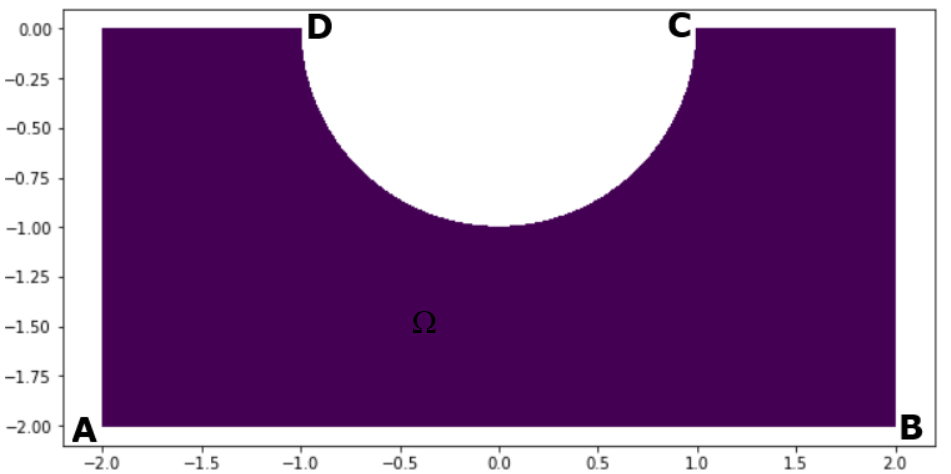

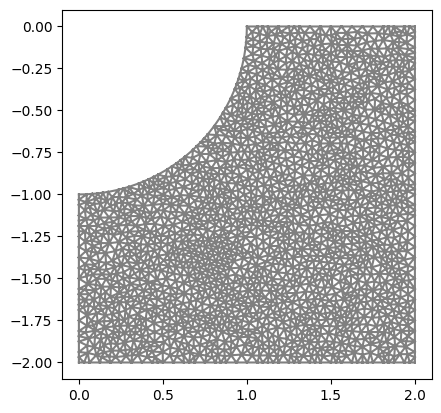

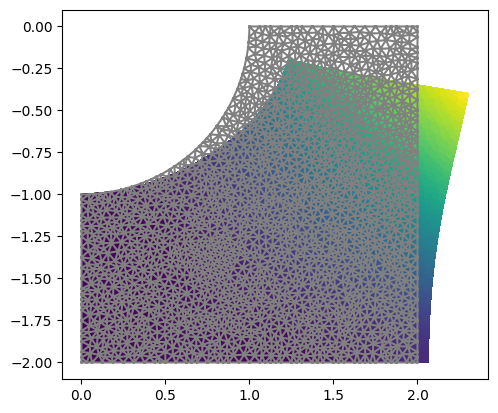

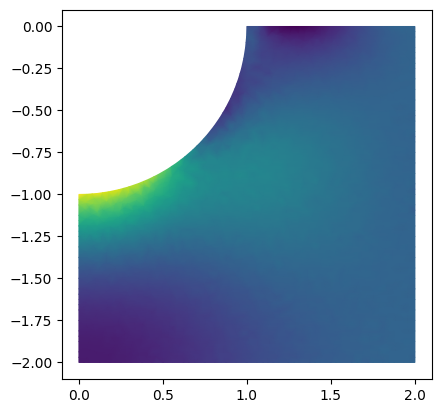

In [25]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

%matplotlib inline
L,L2,R = 2., 0.,1.
N = 40 # mesh density

domain = Rectangle(Point(0.,-2.), Point(L, L2)) - Circle(Point(0., 0.), R)
mesh = generate_mesh(domain, N)
plot(mesh)

# --------------------
# Functions and classes
# --------------------
def left(x, on_boundary):
    return (on_boundary and near(x[0], 0.0))

def bottom(x, on_boundary):
    return (on_boundary and near(x[1]+2, 0.0))

def top(x, on_boundary):
    return (on_boundary and near(x[1], 0.0) and between(x[1] , (1.,2.)))

# Strain function
def epsilon(u):
    return sym(grad(u))

# Stress function
def sigma(u):
    return lambda_*div(u)*Identity(2) + 2*mu*epsilon(u)

# --------------------
# Parameters
# --------------------

# Young's modulus and Poisson's ratio
E =  210e3
nu = 0.35

# Lame's constants
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu = E/2/(1+nu)

# --------------------
# Function spaces
# --------------------
V = VectorFunctionSpace(mesh, "CG", 1)
u = TrialFunction(V)
v = TestFunction(V)

# --------------------
# Boundary conditions
# --------------------
# 1. Define Dirichlet boundary condition
bc1 = DirichletBC(V.sub(0), Constant((0.0)), left)
bc2 = DirichletBC(V.sub(1), Constant((0.0)), bottom)
bc3 = DirichletBC(V.sub(1), Constant((0.0)), top)
bc = [bc1, bc2, bc3]
#
# 2. Definition of Neumann condition domain
#
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundaries.set_all(0)

#   AutoSubDomain: Create SubDomain subclass for given inside() function or lambda function
top = AutoSubDomain(lambda x: near(x[1], sqrt((x[0] -6)**2 + (x[1] - 6)**2) < R * 1.0001))

top.mark(boundaries, 1)

# Define the integration on boundary
ds = Measure("ds", domain=mesh, subdomain_data=boundaries)

#  Unform vertical loading due to self-weight
f = Constant((0.,0.))
# surface load
g = Constant((0.0, -4.0))

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
a = inner(sigma(u), epsilon(v))*dx
l = dot(f, v)*dx + dot(g, v)*ds(1)

u = Function(V, name='Displacement')
# Compute solution
solve(a == l, u, bc,solver_parameters={"linear_solver": "cg","preconditioner":"hypre_amg"})

# Plot Deformed Shape
plt.figure()
# scale factor
factor=10000
plot(factor*u, mode ="displacement")
plot(mesh)
# Plot stress σxx
plt.figure()
plot(sigma(u)[0,0], mode='color')
plt.show()
